# Calculating travel time to ports based on select road improvements in Iraq

A new highway is being proposed in Iraq, this notebook attempts to quantify improved access from this new highway.

1. Agriculture - Calculate travel time to cities from governerates.  
  a. Summarize wheat production as well
2. Industries - calculate travel time from Industrial zones to cities, airports, and Turkish border crossings
3. Health - travel time to health facilities
4. Tourism - Travel time to UNESCO and secondary tourism destinations



In [ ]:
import sys
import os
import rasterio
import overturemaps

import pandas as pd
import geopandas as gpd
import skimage.graph as graph


sys.path.insert(0, r"C:\WBG\Work\Code\GOSTrocks\src")
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.dataMisc as dMisc
from GOSTrocks.misc import tPrint, explodeGDF

sys.path.append(r"C:\WBG\Work\Code\GOSTnetsraster\src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

%load_ext autoreload
%autoreload 2

GDAL is not installed - OGR functionality not available


In [6]:
iso3 = "IRQ"

# Input parameters
m_crs = 3394  # Need to project data to a metres-based projection

# Define input data
base_folder = "C:/WBG/Work/Projects/IRQ_roads/"
if not os.path.exists(os.path.join(base_folder, "DATA")):
    os.makedirs(os.path.join(base_folder, "DATA"))

landcover_file = os.path.join(base_folder, "DATA", "ESA_Globcover.tif")
transport_network = os.path.join(base_folder, "DATA", "transport_network.gpkg")
road_segments_file = os.path.join(base_folder, "DATA", "transport_improvements.gpkg")
major_roads_file = os.path.join(base_folder, "DATA", "major_roads.gpkg")
buildings_file = os.path.join(base_folder, "DATA", "buildings.gpkg")

adm_bounds = dMisc.get_geoboundaries(iso3, "ADM1")
bbox = list(adm_bounds.total_bounds)

# WorldPop 2020 constrained, projected to m_crs
pop_file = os.path.join(base_folder, "DATA", "irq_pop_2024_CN_100m_R2024B_v1.tif")
# https://datacatalog.worldbank.org/int/search/dataset/0038118/Global---International-Ports
port_file = os.path.join(base_folder, "DATA", "attributed_ports.geojson")
# administrative boundaries are used to summarize population
adm2 = dMisc.get_geoboundaries(iso3, "ADM2")
adm1 = dMisc.get_geoboundaries(iso3, "ADM1")

# Define project source data
source_folder = os.path.join(base_folder, "DATA", "SOURCE")
industrial_zones_file = os.path.join(source_folder, "KRG_industrial_zones.gpkg")
airports_file = os.path.join(source_folder, "Iraq_airports.geojson")
border_crossings_file = os.path.join(source_folder, "iraq_new_border_crossings.gpkg")
health_facilities_file = os.path.join(source_folder, "Health", "shapefiles", "iraq.shp")
unesco_file = os.path.join(source_folder, "unesco_sites_iraq.gpkg")
tourism_file = os.path.join(source_folder, "secondary_tourism_sites_iraq.gpkg")

# Define output files
friction_folder = os.path.join(base_folder, "DATA", "FRICTION")
results_folder = os.path.join(base_folder, "RESULTS")
for cFolder in [friction_folder, results_folder]:
    if not os.path.exists(cFolder):
        os.makedirs(cFolder)
pre_friction_file = os.path.join(friction_folder, "FRICTION_pre_intervention.tif")
post_friction_file = os.path.join(friction_folder, "FRICTION_post_intervention.tif")

# Read in data
if not os.path.exists(landcover_file):
    global_landcover = (
        r"R:\GLOBAL\LCVR\Globcover\2015\ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"
    )
    in_lc = rasterio.open(global_landcover)
    temp_landcover_file = landcover_file.replace(".tif", "_temp.tif")
    local_lc = rMisc.clipRaster(in_lc, adm_bounds, temp_landcover_file)
    temp_lc = rasterio.open(temp_landcover_file)
    proj_res = rMisc.project_raster(temp_lc, m_crs)
    with rasterio.open(landcover_file, "w", **proj_res[1]) as outR:
        outR.write(proj_res[0])

in_lc = rasterio.open(landcover_file)
in_pop = rasterio.open(pop_file)
if in_pop.crs != in_lc.crs:
    proj_res = rMisc.standardizeInputRasters(
        in_pop, in_lc, pop_file.replace(".tif", "_proj.tif")
    )

in_pop = rasterio.open(pop_file.replace(".tif", "_proj.tif"))

In [7]:
# Extract SMOD and UCDB datasets
smod_path = r"C:\WBG\Work\data\URBAN\GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V1_0.tif"
out_folder = os.path.join(base_folder, "URBAN")
out_smod = os.path.join(out_folder, "smod_2020.tif")
out_ucdb = os.path.join(out_folder, "ucdb_2024.gpkg")
out_ucdb_big = os.path.join(out_folder, "ucdb_2024_gt1000000.gpkg")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

if not os.path.exists(out_smod):
    smod = rMisc.clipRaster(rasterio.open(smod_path), adm_bounds, out_smod)

if not os.path.exists(out_ucdb):
    good_ucdb_cols = ["ID_UC_G0", "GC_POP_TOT_2025", "geometry"]
    ucdb_file = r"C:\WBG\Work\data\URBAN\GHS_UCDB_GLOBE_R2024A.gpkg"
    ucdb = gpd.read_file(ucdb_file, layer="GHS_UCDB_THEME_SOCIOECONOMIC_GLOBE_R2024A")
    admin_bounds_crs = adm_bounds.to_crs(ucdb.crs)
    matching_ucdb = gpd.sjoin(
        ucdb, admin_bounds_crs, how="inner", predicate="intersects"
    )
    matching_ucdb.loc[:, good_ucdb_cols].to_file(
        out_ucdb, driver="GPKG", layer="ucdb_2024", index=False
    )

if not os.path.exists(out_ucdb_big):
    matching_ucdb = gpd.read_file(out_ucdb)
    matching_ucdb_big = matching_ucdb[matching_ucdb["GC_POP_TOT_2025"] > 1000000]
    matching_ucdb_big.to_file(
        out_ucdb_big, driver="GPKG", layer="ucdb_2024_gt1000000", index=False
    )

In [8]:
# Download roads from Overture
# Download transport network
if not os.path.exists(transport_network):
    transport = overturemaps.record_batch_reader("segment", bbox).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    transport_df.loc[
        :,
        [
            "id",
            "theme",
            "class",
            "subtype",
            "road_surface",
            "speed_limits",
            "width_rules",
            "geometry",
        ],
    ].to_file(transport_network, driver="GPKG")

# process transport to a) remove roads outside IRAQ and b) remove all roads of OSMLR class 3 and 4
if not os.path.exists(major_roads_file):
    roads = gpd.read_file(transport_network)
    roads["OSMLR_class"] = roads["class"].map(speed_tables.OSMLR_Classes)
    roads_joined = gpd.sjoin(roads, adm_bounds, how="inner", predicate="intersects")
    major_roads = roads_joined.loc[
        roads_joined["OSMLR_class"].isin(["OSMLR level 1", "OSMLR level 2"]),
        roads.columns,
    ]
    major_roads.to_file(
        major_roads_file, driver="GPKG", layer="major_roads", index=False
    )

In [9]:
# Process roads to create pre and post friction surfaces
sel_roads = gpd.read_file(road_segments_file)
sel_roads = sel_roads.to_crs(m_crs)
sel_roads["speed"] = 80
all_roads = gpd.read_file(major_roads_file)
all_roads = all_roads.to_crs(m_crs)

In [10]:
all_roads["speed"] = all_roads["class"].map(speed_tables.osm_speed_dict)
all_roads["speed"] = all_roads["speed"].fillna(10.0)
combo_roads = pd.concat([all_roads, sel_roads], ignore_index=True)

lc_speed_table = speed_tables.esaacci_landcover

In [11]:
# Generate pre-intervention friction surface
if not os.path.exists(pre_friction_file):
    pre_roads = all_roads.copy()
    pre_friction = ma.generate_roads_lc_friction(
        in_lc,
        pre_roads,
        lc_travel_table=lc_speed_table,
        out_file=pre_friction_file,
        resolution=in_lc.res[0],
    )
pre_friction = rasterio.open(pre_friction_file)

In [12]:
# Generate post-intervention friction surface
if not os.path.exists(post_friction_file):
    post_roads = combo_roads.copy()
    post_friction = ma.generate_roads_lc_friction(
        in_lc,
        post_roads,
        lc_travel_table=lc_speed_table,
        out_file=post_friction_file,
        resolution=in_lc.res[0],
    )

post_friction = rasterio.open(post_friction_file)

# Calculate travel time

In [19]:
# Calculate travel time to major cities
tt_folder = os.path.join(results_folder, "TRAVEL_TIME")
admin_results_folder = os.path.join(results_folder, "ADMIN_1_SUMMARIES")
if not os.path.exists(admin_results_folder):
    os.makedirs(admin_results_folder)

for dests_file, label in [
    [out_ucdb_big, "major-cities"],
    [out_ucdb, "cities"],
    [industrial_zones_file, "industrial-zones"],
    [airports_file, "airports"],
    [border_crossings_file, "border-crossings"],
    [health_facilities_file, "health-facilities"],
    [unesco_file, "unesco"],
    [tourism_file, "tourism"],
]:
    tPrint(f"Calculating travel time to {label}...")
    dests = explodeGDF(gpd.read_file(dests_file))
    dests = dests.to_crs(m_crs)
    if dests["geometry"].iloc[0].geom_type != "Point":
        dests["geometry"] = dests["geometry"].apply(lambda x: x.centroid)

    frictionD = post_friction.read()[0, :, :]
    frictionD = frictionD * post_friction.res[0]
    mcp = graph.MCP_Geometric(frictionD)
    # ma.calculate_travel_time(post_friction, mcp, dests, out_raster=os.path.join(tt_folder, f"tt_{label}_post.tif"))
    post_tt = ma.summarize_travel_time_populations(
        in_pop,
        post_friction,
        dests,
        mcp,
        adm_bounds,
        out_tt_file=os.path.join(tt_folder, f"tt_{label}_post.tif"),
    )
    pd.DataFrame(post_tt.drop(["geometry"], axis=1)).to_csv(
        os.path.join(admin_results_folder, f"POST_ADM2_tt_{label}.csv")
    )

    frictionD = pre_friction.read()[0, :, :]
    frictionD = frictionD * pre_friction.res[0]
    mcp = graph.MCP_Geometric(frictionD)
    # ma.calculate_travel_time(pre_friction, mcp, dests, out_raster=os.path.join(tt_folder, f"tt_{label}_pre.tif"))
    pre_tt = ma.summarize_travel_time_populations(
        in_pop,
        pre_friction,
        dests,
        mcp,
        adm_bounds,
        out_tt_file=os.path.join(tt_folder, f"tt_{label}_pre.tif"),
    )
    pd.DataFrame(pre_tt.drop(["geometry"], axis=1)).to_csv(
        os.path.join(admin_results_folder, f"PRE_ADM2_tt_{label}.csv")
    )

17:59:30	Calculating travel time to major-cities...
17:59:51	Calculating travel time to cities...
18:00:14	Calculating travel time to industrial-zones...
18:00:36	Calculating travel time to airports...
18:00:59	Calculating travel time to border-crossings...
18:01:22	Calculating travel time to health-facilities...
18:01:53	Calculating travel time to unesco...
18:02:14	Calculating travel time to tourism...


In [21]:
try:
    os.remove(os.path.join(results_folder, "combined_travel_time_adm1.csv"))
except:
    pass
# Aggregate admin summary results
results_files = [
    os.path.join(admin_results_folder, x)
    for x in os.listdir(admin_results_folder)
    if x.endswith(".csv")
]
all_res = []
for result_file in results_files:
    dest = os.path.basename(result_file).split("_")[-1][:-4]
    time = os.path.basename(result_file).split("_")[0]
    tPrint(f"{dest} {time}")
    res = pd.read_csv(result_file, index_col=0)
    res = res.loc[:, ["shapeName", "shapeID", "tt_pop_w"]]
    res = res.rename(columns={"tt_pop_w": f"tt_pop_{dest}_{time}"})
    all_res.append(res)

combo_res = pd.concat(all_res, axis=1)
combo_res.T.drop_duplicates().T.sort_index(axis=1).to_csv(
    os.path.join(results_folder, "combined_travel_time_adm1.csv")
)

18:03:15	airports POST
18:03:15	border-crossings POST
18:03:15	crossings POST
18:03:15	cities POST
18:03:15	health-facilities POST
18:03:15	facilities POST
18:03:15	industrial-zones POST
18:03:15	zones POST
18:03:15	major-cities POST
18:03:15	cities POST
18:03:15	tourism POST
18:03:15	unesco POST
18:03:15	airports PRE
18:03:15	border-crossings PRE
18:03:15	crossings PRE
18:03:15	cities PRE
18:03:15	health-facilities PRE
18:03:15	facilities PRE
18:03:15	industrial-zones PRE
18:03:15	zones PRE
18:03:15	major-cities PRE
18:03:15	cities PRE
18:03:15	tourism PRE
18:03:15	unesco PRE


## Access to industries

In [15]:
all_tt_rasters = [
    os.path.join(tt_folder, x) for x in os.listdir(tt_folder) if x.endswith(".tif")
]
# Buffer the industrial zones and summarize travel time within
industrial_zones = gpd.read_file(industrial_zones_file)
industrial_zones = industrial_zones.to_crs(m_crs)
industrial_res = industrial_zones.copy()
for buffer in [1000, 2500, 5000, 10000]:
    buffered_zones = industrial_zones.copy()
    buffered_zones["geometry"] = buffered_zones["geometry"].buffer(buffer)
    total_pop = rMisc.zonalStats(buffered_zones, in_pop, minVal=0, return_df=True)
    industrial_res[f"pop_{buffer}_sum"] = total_pop["SUM"].values
    for tt_raster in all_tt_rasters:
        tt_label = os.path.basename(tt_raster).split("_")[1]
        time_label = os.path.basename(tt_raster).split("_")[-1][:-4]
        tPrint(
            f"Summarizing {time_label} {tt_label} travel time within {buffer}m of industrial zones..."
        )
        res = rMisc.zonalStats(buffered_zones, tt_raster, return_df=True)
        industrial_res[f"tt_{time_label}_{tt_label}_{buffer}_mean"] = res["MEAN"]
        industrial_res[f"tt_{time_label}_{tt_label}_{buffer}_max"] = res["MAX"]

industrial_res.drop(["geometry"], axis=1).to_csv(
    os.path.join(results_folder, "industrial_zones_travel_time.csv")
)

17:43:22	Summarizing post airports travel time within 1000m of industrial zones...
17:43:22	Summarizing pre airports travel time within 1000m of industrial zones...
17:43:22	Summarizing post border travel time within 1000m of industrial zones...
17:43:23	Summarizing pre border travel time within 1000m of industrial zones...
17:43:23	Summarizing post cities travel time within 1000m of industrial zones...
17:43:23	Summarizing pre cities travel time within 1000m of industrial zones...
17:43:23	Summarizing post health travel time within 1000m of industrial zones...
17:43:23	Summarizing pre health travel time within 1000m of industrial zones...
17:43:23	Summarizing post industrial travel time within 1000m of industrial zones...
17:43:23	Summarizing pre industrial travel time within 1000m of industrial zones...
17:43:23	Summarizing post major travel time within 1000m of industrial zones...
17:43:23	Summarizing pre major travel time within 1000m of industrial zones...
17:43:24	Summarizing pos

c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:27	Summarizing post airports travel time within 10000m of industrial zones...
17:43:28	Summarizing pre airports travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:28	Summarizing post border travel time within 10000m of industrial zones...
17:43:28	Summarizing pre border travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:28	Summarizing post cities travel time within 10000m of industrial zones...
17:43:28	Summarizing pre cities travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:28	Summarizing post health travel time within 10000m of industrial zones...
17:43:28	Summarizing pre health travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:28	Summarizing post industrial travel time within 10000m of industrial zones...
17:43:28	Summarizing pre industrial travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:29	Summarizing post major travel time within 10000m of industrial zones...
17:43:29	Summarizing pre major travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:29	Summarizing post tourism travel time within 10000m of industrial zones...
17:43:29	Summarizing pre tourism travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

17:43:29	Summarizing post unesco travel time within 10000m of industrial zones...
17:43:29	Summarizing pre unesco travel time within 10000m of industrial zones...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


## Access to health care facilities

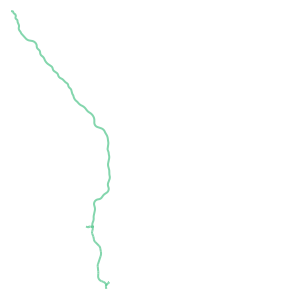

In [16]:
# Buffer proposed roads and summarize travel time within
proposed_roads = gpd.read_file(road_segments_file)
proposed_roads = proposed_roads.to_crs(m_crs)
proposed_roads = proposed_roads.dissolve(by="Section")
proposed_roads.union_all()

In [17]:
for buffer in [1000, 2500, 5000, 10000]:
    buffered_roads = proposed_roads.copy()
    buffered_roads["geometry"] = buffered_roads["geometry"].buffer(buffer)
    total_pop = rMisc.zonalStats(buffered_roads, in_pop, minVal=0, return_df=True)
    proposed_roads[f"pop_{buffer}_sum"] = total_pop["SUM"].values
    for tt_raster in all_tt_rasters:
        tt_label = os.path.basename(tt_raster).split("_")[1]
        time_label = os.path.basename(tt_raster).split("_")[-1][:-4]
        tPrint(
            f"Summarizing {time_label} {tt_label} travel time within {buffer}m of proposed roads..."
        )
        res = rMisc.zonalStats(buffered_roads, tt_raster, return_df=True)
        proposed_roads[f"tt_{time_label}_{tt_label}_{buffer}_mean"] = res["MEAN"].values
        proposed_roads[f"tt_{time_label}_{tt_label}_{buffer}_max"] = res["MAX"].values
proposed_roads.drop(["geometry"], axis=1).to_csv(
    os.path.join(results_folder, "proposed_roads_travel_time.csv")
)

17:43:31	Summarizing post airports travel time within 1000m of proposed roads...
17:43:32	Summarizing pre airports travel time within 1000m of proposed roads...
17:43:32	Summarizing post border travel time within 1000m of proposed roads...
17:43:33	Summarizing pre border travel time within 1000m of proposed roads...
17:43:33	Summarizing post cities travel time within 1000m of proposed roads...
17:43:34	Summarizing pre cities travel time within 1000m of proposed roads...
17:43:34	Summarizing post health travel time within 1000m of proposed roads...
17:43:35	Summarizing pre health travel time within 1000m of proposed roads...
17:43:35	Summarizing post industrial travel time within 1000m of proposed roads...
17:43:36	Summarizing pre industrial travel time within 1000m of proposed roads...
17:43:36	Summarizing post major travel time within 1000m of proposed roads...
17:43:37	Summarizing pre major travel time within 1000m of proposed roads...
17:43:37	Summarizing post tourism travel time wi

c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:53	Summarizing pre airports travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:54	Summarizing post border travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:54	Summarizing pre border travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:54	Summarizing post cities travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:55	Summarizing pre cities travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:55	Summarizing post health travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:55	Summarizing pre health travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:55	Summarizing post industrial travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:56	Summarizing pre industrial travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:56	Summarizing post major travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:56	Summarizing pre major travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:57	Summarizing post tourism travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:57	Summarizing pre tourism travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:57	Summarizing post unesco travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


17:43:58	Summarizing pre unesco travel time within 10000m of proposed roads...


c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\WBG\Anaconda3\envs\gn\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


## Tourism access

In [18]:
unesco_sites = gpd.read_file(unesco_file)
unesco_sites = unesco_sites.to_crs(m_crs)
tourism_sites = gpd.read_file(tourism_file)
tourism_sites = tourism_sites.to_crs(m_crs)
all_tourism = pd.concat([unesco_sites, tourism_sites], ignore_index=True)

for buffer in [1000, 2500, 5000, 10000]:
    buffered_tourism = all_tourism.copy()
    buffered_tourism["geometry"] = buffered_tourism["geometry"].buffer(buffer)
    total_pop = rMisc.zonalStats(buffered_tourism, in_pop, minVal=0, return_df=True)
    buffered_tourism[f"pop_{buffer}_sum"] = total_pop["SUM"].values
    for tt_raster in all_tt_rasters:
        tt_label = os.path.basename(tt_raster).split("_")[1]
        time_label = os.path.basename(tt_raster).split("_")[-1][:-4]
        tPrint(
            f"Summarizing {time_label} {tt_label} travel time within {buffer}m of tourism sites..."
        )
        res = rMisc.zonalStats(buffered_tourism, tt_raster, return_df=True)
        buffered_tourism[f"tt_{time_label}_{tt_label}_{buffer}_mean"] = res[
            "MEAN"
        ].values
        buffered_tourism[f"tt_{time_label}_{tt_label}_{buffer}_max"] = res["MAX"].values

buffered_tourism.drop(["geometry"], axis=1).to_csv(
    os.path.join(results_folder, "tourism_travel_time.csv")
)

17:43:58	Summarizing post airports travel time within 1000m of tourism sites...
17:43:58	Summarizing pre airports travel time within 1000m of tourism sites...
17:43:59	Summarizing post border travel time within 1000m of tourism sites...
17:43:59	Summarizing pre border travel time within 1000m of tourism sites...
17:43:59	Summarizing post cities travel time within 1000m of tourism sites...
17:43:59	Summarizing pre cities travel time within 1000m of tourism sites...
17:43:59	Summarizing post health travel time within 1000m of tourism sites...
17:43:59	Summarizing pre health travel time within 1000m of tourism sites...
17:43:59	Summarizing post industrial travel time within 1000m of tourism sites...
17:43:59	Summarizing pre industrial travel time within 1000m of tourism sites...
17:43:59	Summarizing post major travel time within 1000m of tourism sites...
17:44:00	Summarizing pre major travel time within 1000m of tourism sites...
17:44:00	Summarizing post tourism travel time within 1000m o

# DEBUGGING

In [ ]:
cities = gpd.read_file(out_ucdb)
cities.sort_values("GC_POP_TOT_2025", ascending=False, inplace=True)
"""cities.drop_duplicates(subset=['ID_UC_G0'], keep='first', inplace=True)
cities.to_file(out_ucdb, driver="GPKG", layer="ucdb_2024", index=False)"""

In [ ]:
pd.options.display.float_format = "{:.2f}".format

cities.head(20)